In [1]:
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random

In [2]:
np.random.seed(1337)

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

In [6]:
n = x_test_noisy
n = n.astype('float32') / 255

In [7]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

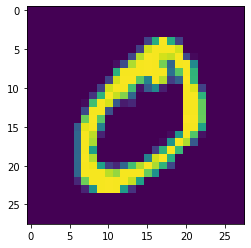

In [8]:
plt.imshow(x_train[1])

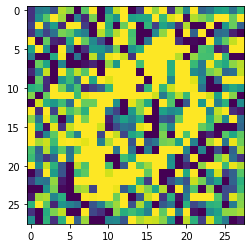

In [9]:
plt.imshow(x_train_noisy[1])

In [10]:
def concat_vh(list_2d):
    print(len(list_2d))
      # return final image
    return cv2.vconcat([cv2.hconcat(list_h) 
                        for list_h in list_2d])

In [11]:
img_tile = concat_vh([[x_test_noisy[0], x_test_noisy[1], x_test_noisy[2]],
                      [x_test_noisy[3], x_test_noisy[4], x_test_noisy[5]]])

2


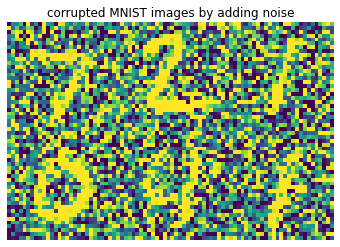

In [12]:
plt.imshow(img_tile)
plt.title('corrupted MNIST images by adding noise')
plt.axis('off')
plt.savefig('noisy image.png', dpi=300, bbox_inches='tight')

In [13]:
img_tile = concat_vh([[x_test[0], x_test[1], x_test[2]],
                      [x_test[3], x_test[4], x_test[5]]])

2


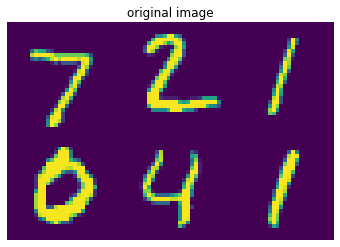

In [14]:
plt.imshow(img_tile)
plt.title('original image')
plt.axis('off')
plt.savefig('original_image.png', dpi=300, bbox_inches='tight')


In [15]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16

In [16]:
layer_filters = [64, 96]

In [17]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

In [18]:
for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
    

In [19]:
shape = K.int_shape(x)

In [20]:
shape

(None, 7, 7, 96)

In [21]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [22]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 96)          55392     
_________________________________________________________________
flatten (Flatten)            (None, 4704)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                75280     
Total params: 131,312
Trainable params: 131,312
Non-trainable params: 0
_________________________________________________________________


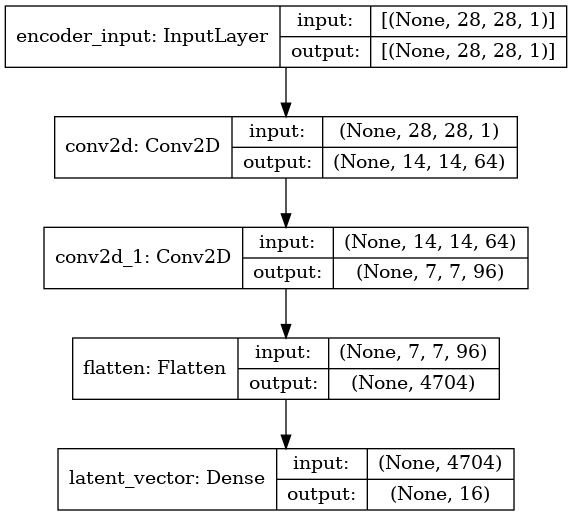

In [23]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)

In [24]:
latent_dim,

(16,)

In [25]:
latent_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]* shape[2]* shape[3])(latent_input)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [26]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, padding='same', strides=2, activation='relu')(x)

In [27]:
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid',
                         name='decoder_output')(x)

In [28]:
decoder = Model(latent_input, outputs, name='decoder')

In [29]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 4704)              79968     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 96)        83040     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        55360     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         577       
Total params: 218,945
Trainable params: 218,945
Non-trainable params: 0
_____________________________________________________

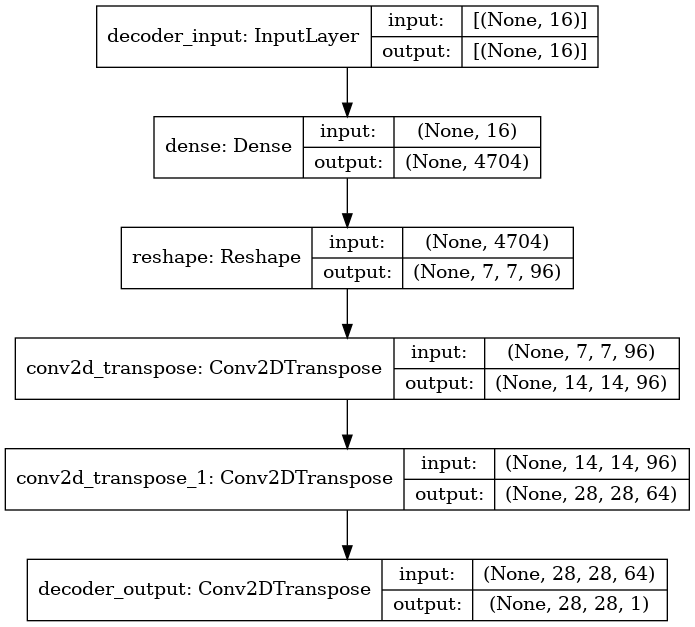

In [30]:
plot_model(decoder, show_shapes=True)

In [31]:
autoencoder = Model(inputs, decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                131312    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         218945    
Total params: 350,257
Trainable params: 350,257
Non-trainable params: 0
_________________________________________________________________


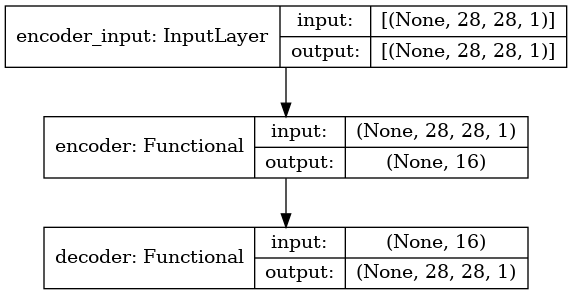

In [32]:
plot_model(autoencoder, show_shapes=True)

In [33]:
autoencoder.compile(loss='mse', optimizer='adam')

In [34]:
autoencoder.fit(x_train_noisy,x_train,
                validation_data=(x_test_noisy, x_test),epochs=10,
                batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0518 - val_loss: 0.0191
Epoch 2/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0187 - val_loss: 0.0172
Epoch 3/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0170 - val_loss: 0.0165
Epoch 4/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0162 - val_loss: 0.0162
Epoch 5/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0156 - val_loss: 0.0158
Epoch 6/10
1875/1875 [==============================] - 80s 42ms/step - loss: 0.0152 - val_loss: 0.0155
Epoch 7/10
1875/1875 [==============================] - 80s 42ms/step - loss: 0.0149 - val_loss: 0.0155
Epoch 8/10
1875/1875 [==============================] - 80s 42ms/step - loss: 0.0146 - val_loss: 0.0153
Epoch 9/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0145 - val_loss: 0.0153
Epoch 10/10
1875/1875 [==============================] - 77s 41m

In [35]:
x_test.shape

(10000, 28, 28, 1)

In [36]:
x_test_noisy.shape

(10000, 28, 28, 1)

In [37]:
x_train.shape

(60000, 28, 28, 1)

In [38]:
x_train_noisy.shape

(60000, 28, 28, 1)

In [39]:
x_decoded = autoencoder.predict(x_test_noisy)

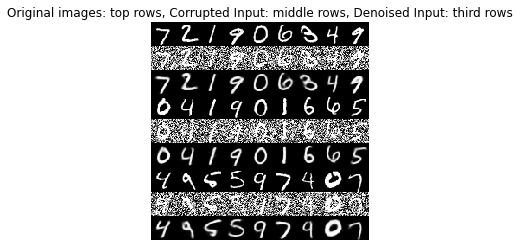

In [45]:
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
'Corrupted Input: middle rows, '
'Denoised Input: third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()